In [1]:
TRIAL_ID = '16dice_full'
USE_TBX = False
CHECKPOINT = None
SAVE_CP = True

COEFF_REC = 1#e-3
COEFF_KLD = 1#e5    # beta

In [2]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset,DataLoader
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import os

from utils import plot_3d_mesh, VertDataset, ResizeTo
import utils as ut
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#Define paramaters
VOL_SIZE = 16
EPOCHS = 50
LEARNING_RATE = 1e-3
LOG_INTERVAL = 3

N = None    # None for full dataset
BATCH_SIZE = 64
Z_DIMS = 20

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_path = pathlib.Path("./for_VAE/npz")
val_path = pathlib.Path("./for_VAE/val")
results_dir = pathlib.Path("./results/%s" % TRIAL_ID)
results_dir.mkdir(parents=True, exist_ok=True)

In [4]:
if USE_TBX:
    from tensorboardX import SummaryWriter
    #SummaryWriter encapsulates everything
    log_dir = pathlib.Path('./logs/%s' % TRIAL_ID)
    writer = SummaryWriter(log_dir)

In [5]:
train_dataset = VertDataset(train_path,n=N, transform=transforms.Compose([ResizeTo(VOL_SIZE),
                                                               transforms.ToTensor()]))
val_dataset = VertDataset(val_path,n=N, transform=transforms.Compose([ResizeTo(VOL_SIZE),
                                                               transforms.ToTensor()]))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
print('Number of training samples: ',len(train_dataset))
print('Number of training batches: ',len(train_loader))
print('Number of validaiton samples: ',len(val_dataset))

Number of training samples:  1395
Number of training batches:  22
Number of validaiton samples:  32


In [6]:
# x = dataset[0]
# print(x.size())
# print(x.unique())
# plot_3d_mesh(x)
# del x

In [7]:
def init_weights(m):
    if isinstance(m, nn.Linear):
# #         torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.kaiming_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    elif isinstance(m, nn.Conv3d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

In [8]:
from vae16 import VAE
model = VAE().to(device)
# weights_init = ut.init_weights(init_type='normal')
# model.apply(weights_init)
model.apply(init_weights)       

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [9]:
class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()

    def forward(self, probs, targets):
        smooth = 1
        num = targets.size(0)
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)

        score = 2. * (intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        score = 1 - score.sum() / num
        return score

dice_loss = SoftDiceLoss()

In [10]:
def loss_function(recon_x, x, mu, logvar):
    batch_size = recon_x.size(0)
    #measure of how well reconstruction matches input
#     rec_loss = F.binary_cross_entropy(recon_x, x) #, reduction='elementwise_mean')
    rec_loss = dice_loss(recon_x, x)
    
    #measure of distance btw learned distribution and Normal Gaussian
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD /= batch_size * 16*16*16    
    
    #Normalize over batches
#     rec_loss = rec_loss / batch_size
#     KLD = KLD / batch_size
    
    rec_loss *= COEFF_REC 
    KLD *= COEFF_KLD

    loss = rec_loss + KLD
    return loss, rec_loss, KLD

In [11]:
# Training setup
loss_history = list()
rec_loss_history = list()
kl_loss_history = list()
val_rec_loss_history = list()

iters=0
N_batches_train = len(train_loader)

start_epoch = 0
if CHECKPOINT is not None:
    checkpoint_path = '%s/%s' % (results_dir, CHECKPOINT)
    model, optimizer, start_epoch, loss_history, rec_loss_history, kl_loss_history = ut.load_checkpoint(model, optimizer,filename = checkpoint_path)
    iters = start_epoch * N_batches_train
    
    model = model.to(device)
    for state in optimizer.state.values():
        for k, v in state.items():
            if torch.is_tensor(v):
                state[k] = v.to(device)

In [12]:
import time
end_epoch = start_epoch + EPOCHS
epoch = start_epoch
for epoch in range(start_epoch, end_epoch):    
    start = time.time()
################## TRAIN ########################
    model.train()
    train_loss = 0
    
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(data)
        loss, rec_loss, kl_loss = loss_function(recon_batch, data, mu, logvar)
        if USE_TBX:
            writer.add_scalar('Loss/Rec',rec_loss.detach().item(),iters)
            writer.add_scalar('Loss/KL',kl_loss.detach().item(),iters)
            writer.add_scalar('Loss/Total_Loss',loss.detach().item(),iters)
        
        
        loss_history.append( loss.item() )
        rec_loss_history.append( rec_loss.item() )
        kl_loss_history.append( kl_loss.item() )
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {:02d} [{:04d}/{:04d} ({:.0f}%)]\tRec: {:.6f}, KLD: {:.6f}, Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                rec_loss.item(), kl_loss.item(), loss.item() ))
        iters+=1
    #Finished one epoch        
    end = time.time()
    print('====> Epoch: {:02d} Time: {:.5f}'.format(
          epoch, end-start ))

################## VALIDATION ########################    
    print('-------------- Validation --------------')
    model.eval()
    l_sum = 0
    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader):
            data = data.to(device)
            recon_batch, my, logvar = model(data)
#             rec_loss = F.binary_cross_entropy(recon_batch, data)
            rec_loss = dice_loss(recon_batch, data)
            l_sum += rec_loss.item()
        val_rec_loss_history.append( l_sum / (batch_idx + 1) )
        print('\tVal rec: {:.3f}'.format(
            val_rec_loss_history[-1] ))    
        
        
    # SAVE CHECKPOINT EVERY 10 EPOCHS
    if epoch % 10 == 0:
        ut.save_checkpoint(results_dir, epoch, model, optimizer, loss_history, rec_loss_history, kl_loss_history)
        print('Save checkpoint after epoch ',epoch)
    print('======================================================')

Train Epoch: 00 [0000/1395 (0%)]	Rec: 0.873759, KLD: 0.000255, Loss: 0.874014
Train Epoch: 00 [0192/1395 (14%)]	Rec: 0.850169, KLD: 0.000172, Loss: 0.850341
Train Epoch: 00 [0384/1395 (27%)]	Rec: 0.837501, KLD: 0.000149, Loss: 0.837649
Train Epoch: 00 [0576/1395 (41%)]	Rec: 0.810727, KLD: 0.008395, Loss: 0.819122
Train Epoch: 00 [0768/1395 (55%)]	Rec: 0.786010, KLD: 0.001191, Loss: 0.787201
Train Epoch: 00 [0960/1395 (68%)]	Rec: 0.757775, KLD: 0.003153, Loss: 0.760928
Train Epoch: 00 [1152/1395 (82%)]	Rec: 0.721580, KLD: 0.003931, Loss: 0.725512
Train Epoch: 00 [1071/1395 (95%)]	Rec: 0.611869, KLD: 0.002881, Loss: 0.614749
====> Epoch: 00 Time: 17.16199
-------------- Validation --------------
	Val rec: 0.593
Save checkpoint after epoch  0
Train Epoch: 01 [0000/1395 (0%)]	Rec: 0.588943, KLD: 0.003285, Loss: 0.592227
Train Epoch: 01 [0192/1395 (14%)]	Rec: 0.492474, KLD: 0.011212, Loss: 0.503686
Train Epoch: 01 [0384/1395 (27%)]	Rec: 0.482370, KLD: 0.004200, Loss: 0.486571
Train Epoch: 0

Train Epoch: 10 [1152/1395 (82%)]	Rec: 0.251187, KLD: 0.007481, Loss: 0.258668
Train Epoch: 10 [1071/1395 (95%)]	Rec: 0.263365, KLD: 0.007908, Loss: 0.271273
====> Epoch: 10 Time: 15.91616
-------------- Validation --------------
	Val rec: 0.228
Save checkpoint after epoch  10
Train Epoch: 11 [0000/1395 (0%)]	Rec: 0.239068, KLD: 0.007943, Loss: 0.247011
Train Epoch: 11 [0192/1395 (14%)]	Rec: 0.228113, KLD: 0.007248, Loss: 0.235361
Train Epoch: 11 [0384/1395 (27%)]	Rec: 0.222749, KLD: 0.008103, Loss: 0.230852
Train Epoch: 11 [0576/1395 (41%)]	Rec: 0.251451, KLD: 0.008146, Loss: 0.259597
Train Epoch: 11 [0768/1395 (55%)]	Rec: 0.240880, KLD: 0.007030, Loss: 0.247910
Train Epoch: 11 [0960/1395 (68%)]	Rec: 0.226621, KLD: 0.006742, Loss: 0.233363
Train Epoch: 11 [1152/1395 (82%)]	Rec: 0.231147, KLD: 0.007642, Loss: 0.238789
Train Epoch: 11 [1071/1395 (95%)]	Rec: 0.226558, KLD: 0.008781, Loss: 0.235339
====> Epoch: 11 Time: 16.30960
-------------- Validation --------------
	Val rec: 0.226
Tra

Train Epoch: 21 [0384/1395 (27%)]	Rec: 0.190289, KLD: 0.009508, Loss: 0.199797
Train Epoch: 21 [0576/1395 (41%)]	Rec: 0.190178, KLD: 0.009267, Loss: 0.199445
Train Epoch: 21 [0768/1395 (55%)]	Rec: 0.195778, KLD: 0.009186, Loss: 0.204965
Train Epoch: 21 [0960/1395 (68%)]	Rec: 0.197163, KLD: 0.008586, Loss: 0.205750
Train Epoch: 21 [1152/1395 (82%)]	Rec: 0.187339, KLD: 0.009224, Loss: 0.196563
Train Epoch: 21 [1071/1395 (95%)]	Rec: 0.189389, KLD: 0.009846, Loss: 0.199235
====> Epoch: 21 Time: 16.00151
-------------- Validation --------------
	Val rec: 0.183
Train Epoch: 22 [0000/1395 (0%)]	Rec: 0.186226, KLD: 0.009248, Loss: 0.195474
Train Epoch: 22 [0192/1395 (14%)]	Rec: 0.188239, KLD: 0.009051, Loss: 0.197290
Train Epoch: 22 [0384/1395 (27%)]	Rec: 0.194682, KLD: 0.010293, Loss: 0.204975
Train Epoch: 22 [0576/1395 (41%)]	Rec: 0.182973, KLD: 0.009245, Loss: 0.192218
Train Epoch: 22 [0768/1395 (55%)]	Rec: 0.181814, KLD: 0.009405, Loss: 0.191220
Train Epoch: 22 [0960/1395 (68%)]	Rec: 0.177

	Val rec: 0.174
Train Epoch: 32 [0000/1395 (0%)]	Rec: 0.168858, KLD: 0.010191, Loss: 0.179049
Train Epoch: 32 [0192/1395 (14%)]	Rec: 0.176451, KLD: 0.010674, Loss: 0.187124
Train Epoch: 32 [0384/1395 (27%)]	Rec: 0.159073, KLD: 0.010799, Loss: 0.169873
Train Epoch: 32 [0576/1395 (41%)]	Rec: 0.171988, KLD: 0.009766, Loss: 0.181754
Train Epoch: 32 [0768/1395 (55%)]	Rec: 0.170424, KLD: 0.009390, Loss: 0.179814
Train Epoch: 32 [0960/1395 (68%)]	Rec: 0.175981, KLD: 0.010050, Loss: 0.186031
Train Epoch: 32 [1152/1395 (82%)]	Rec: 0.169150, KLD: 0.011134, Loss: 0.180284
Train Epoch: 32 [1071/1395 (95%)]	Rec: 0.162694, KLD: 0.010878, Loss: 0.173571
====> Epoch: 32 Time: 16.31838
-------------- Validation --------------
	Val rec: 0.171
Train Epoch: 33 [0000/1395 (0%)]	Rec: 0.163494, KLD: 0.010099, Loss: 0.173593
Train Epoch: 33 [0192/1395 (14%)]	Rec: 0.165653, KLD: 0.010039, Loss: 0.175692
Train Epoch: 33 [0384/1395 (27%)]	Rec: 0.159962, KLD: 0.009444, Loss: 0.169406
Train Epoch: 33 [0576/1395 (4

Train Epoch: 42 [0960/1395 (68%)]	Rec: 0.157392, KLD: 0.010651, Loss: 0.168043
Train Epoch: 42 [1152/1395 (82%)]	Rec: 0.157870, KLD: 0.010807, Loss: 0.168677
Train Epoch: 42 [1071/1395 (95%)]	Rec: 0.153984, KLD: 0.011196, Loss: 0.165180
====> Epoch: 42 Time: 16.53381
-------------- Validation --------------
	Val rec: 0.165
Train Epoch: 43 [0000/1395 (0%)]	Rec: 0.142969, KLD: 0.011374, Loss: 0.154342
Train Epoch: 43 [0192/1395 (14%)]	Rec: 0.151065, KLD: 0.010570, Loss: 0.161636
Train Epoch: 43 [0384/1395 (27%)]	Rec: 0.159458, KLD: 0.010893, Loss: 0.170351
Train Epoch: 43 [0576/1395 (41%)]	Rec: 0.141721, KLD: 0.010966, Loss: 0.152687
Train Epoch: 43 [0768/1395 (55%)]	Rec: 0.156846, KLD: 0.010790, Loss: 0.167637
Train Epoch: 43 [0960/1395 (68%)]	Rec: 0.153887, KLD: 0.010702, Loss: 0.164588
Train Epoch: 43 [1152/1395 (82%)]	Rec: 0.153179, KLD: 0.010765, Loss: 0.163944
Train Epoch: 43 [1071/1395 (95%)]	Rec: 0.146046, KLD: 0.010585, Loss: 0.156631
====> Epoch: 43 Time: 16.53680
-------------

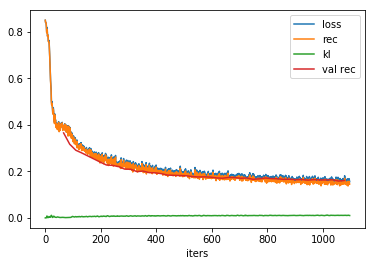

In [19]:
#plot loss
SHOW_FROM = 3
plt.figure(figsize = (20,10))
plt.plot(loss_history[SHOW_FROM:], label="loss")
plt.plot(rec_loss_history[SHOW_FROM:], label="rec")
plt.plot(kl_loss_history[SHOW_FROM:], label="kl")
plt.plot(list(range(0,iters,N_batches_train))[SHOW_FROM:],val_rec_loss_history[SHOW_FROM:], label="val rec")
plt.xlabel("iters")
plt.legend(loc='upper right')

In [14]:
#Save checkpoint
if EPOCHS and SAVE_CP != 0: 
    ut.save_checkpoint(results_dir, epoch, model, optimizer, loss_history, rec_loss_history, kl_loss_history)
    print('Save checkpoint after epoch ',epoch)

Save checkpoint after epoch  49


In [15]:
#Check reconstruction
inbatch_idx = 1
with torch.no_grad():
    x = next(iter(train_loader))
    x = x.to(device)
    recon_x, _, _ = model(x)
    
    plot_3d_mesh(x[inbatch_idx])
    plot_3d_mesh(recon_x[inbatch_idx])

In [16]:
#CHECK GENERATION RESULTS
print('Generating samples')
N_samples = 3
with torch.no_grad():
    z_samples = torch.randn(N_samples, Z_DIMS).to(device)
    samples = model.decode(z_samples)
        
for x in samples:
        plot_3d_mesh(x)
#     plot_3d_mesh(ut.do_threshold(x, eps=0.3))
#     plot_3d_mesh(np.round(x))    

Generating samples


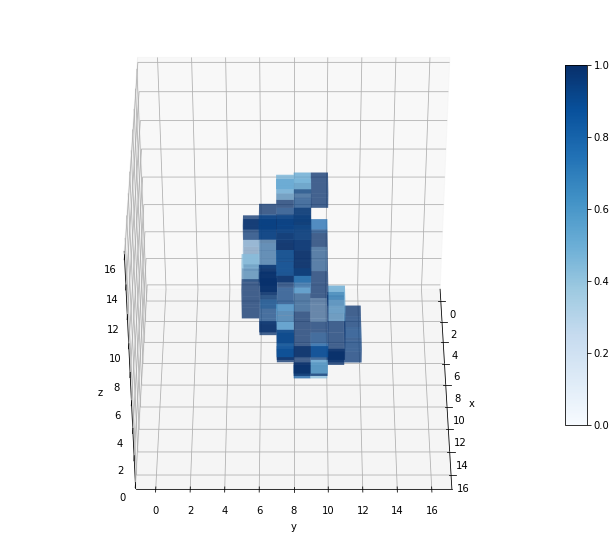

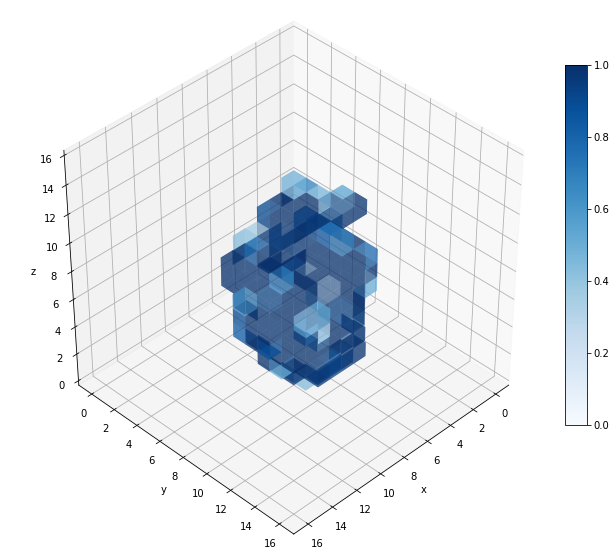

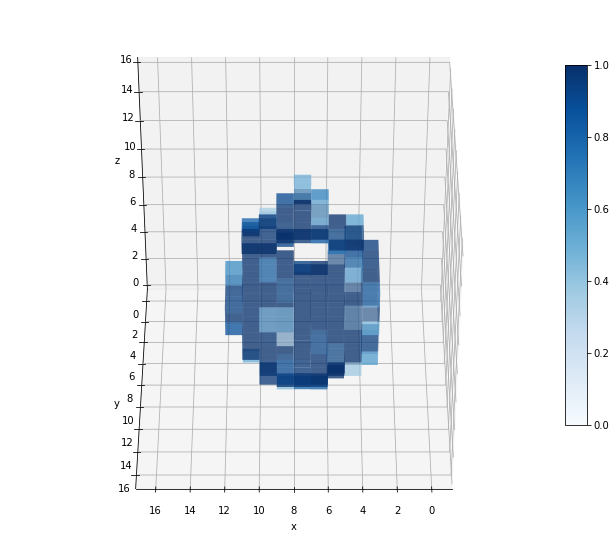

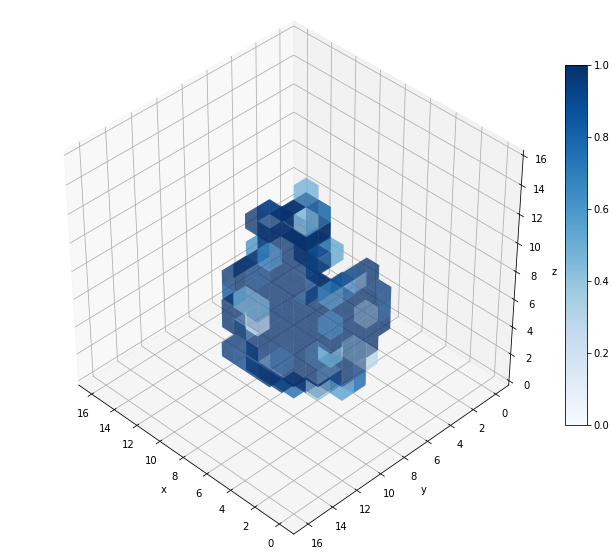

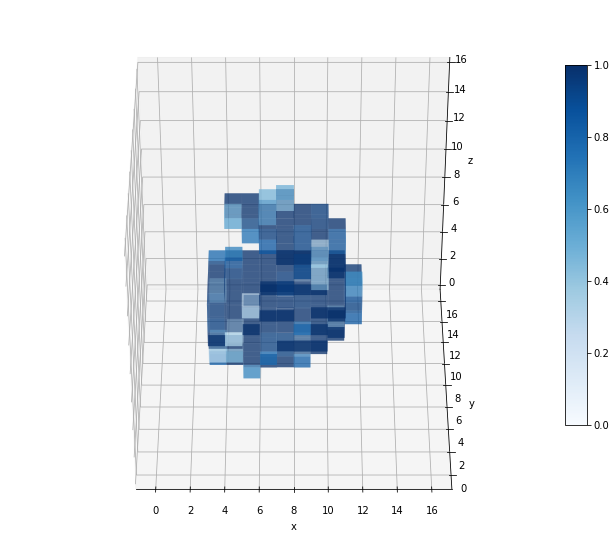

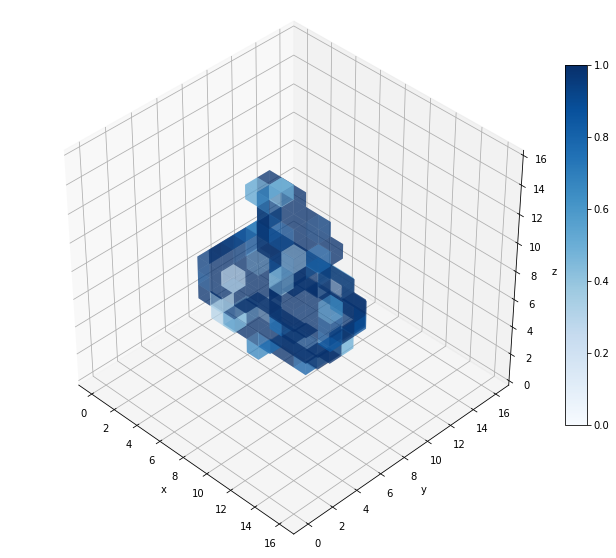

In [17]:
sample = samples[0][0]
thresholded = ut.do_threshold(sample, eps=0.3)
ut.plot_voxels_views(thresholded)